In [1]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline


# sys.path.append("/path/to/your/project")
from hockey.hockey_env import HockeyEnv_BasicOpponent, Mode

try:
    from models.ddpg.DDPG import DDPGAgent
    from models.ddpg.DDPGTrainer import DDPGTrainer
except ImportError:
    print("Could not import DDPG.")
    raise

In [2]:
# The single-agent wrapper environment is `HockeyEnv_BasicOpponent`.
# By default:
#   - It uses mode=Mode.NORMAL
#   - keep_mode=True
#   - An opponent with `weak_opponent=False` or True
#
# action_space of shape (4,) 
# suitable for a single-agent continuous control algorithms

env = HockeyEnv_BasicOpponent(
    mode=Mode.NORMAL,   # or Mode.TRAIN_SHOOTING, Mode.TRAIN_DEFENSE
    weak_opponent=False # whether the opponent is weaker or not
)

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

# For reference:
# - The observation space is Box(...) with shape (18,) if keep_mode=True.
# - The action space is Box(...) with shape (4,). 
#   The four actions: 
#       1) Force in x, 
#       2) Force in y, 
#       3) Torque (racket rotation),
#       4) Shoot command (0 or 1).

Observation space: Box(-inf, inf, (18,), float32)
Action space: Box(-1.0, 1.0, (4,), float32)


In [4]:
training_config = {
    "epsilon_start": 1.0,   
    "epsilon_min": 0.05,  
    "epsilon_decay": 0.999,  
    "max_episodes": 10000,     
    "max_timesteps": 250,    
    "log_interval": 20,
    "save_interval": 1000,
    "render": False,         
    "train_iter": 32,       
    "seed": 42              
}

model_config = {
    "eps": 0.0,                  
    "discount": 0.95,      
    "buffer_size": int(1e6),     
    "batch_size": 128,            
    "learning_rate_actor": 1e-4, 
    "learning_rate_critic": 1e-4,
    "hidden_sizes_actor": [256, 256],
    "hidden_sizes_critic": [256, 256],
    "update_target_every": 100,
    "use_target_net": True
}

experiment_path = "rl_experiments/experiments/HockeyEnv_DDPG_Test"

# Initialize trainer
trainer = DDPGTrainer(
    env_name="HockeyEnv",
    training_config=training_config,
    model_config=model_config,
    experiment_path=experiment_path,
    wandb_run=None 
)


2025-01-26 10:25:16 [INFO] Logger initialized. Writing logs to rl_experiments/experiments/HockeyEnv_DDPG_Test/results/training/logs/DDPG_HockeyEnv_eps0.0_alr0.0001_clr0.0001_gamma0.95.log
2025-01-26 10:25:16 [INFO] Initialized random seeds to 42.


In [5]:
checkpoint_path = "EpsilonGreedy0.999/DDPG_HockeyEnv_eps0_alr0.0001_clr0.0001_gamma0.95_checkpoint_ep10000.pth"

checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# 4) Restore the agent's networks
trainer.agent.restore_state(checkpoint)

/var/folders/x2/dvcm78hn67g79fdt399dzt8c0000gn/T/ipykernel_3095/3852975789.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_l

In [9]:
num_test_episodes = 100
cumulative_rewards = []
win_count = 0
for ep in range(num_test_episodes):
    obs, _ = env.reset()
    done = False
    episode_reward = 0.0
    while not done:
        # set simple deterministic policy
        action = trainer.agent.act(obs, evaluate=True)  
        obs, reward, done, trunc, info = env.step(action)
        episode_reward += reward

        env.render(mode="rgb_array")

        if done or trunc:
            break
    cumulative_rewards.append(episode_reward)
    win_count += info["winner"] 

env.close()

print("Average cumulative reward:", np.mean(cumulative_rewards))
print("Win rate:", win_count / num_test_episodes)



Average cumulative reward: 1.6466697691713086
Win rate: 0.3


In [7]:
# plot the cumulative rewards
plt.plot(cumulative_rewards)
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Rewards over Episodes")
plt.show()


/var/folders/x2/dvcm78hn67g79fdt399dzt8c0000gn/T/ipykernel_2728/4163330427.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [8]:
import imageio
import numpy as np

num_test_episodes = 50

for ep in range(num_test_episodes):
    frames = []
    obs, info = env.reset()
    done = False
    episode_reward = 0.0
    while not done:
        # Act with no noise at test time
        action = trainer.agent.act(obs, evaluate=True)
        obs, reward, done, trunc, info = env.step(action)
        episode_reward += reward

        # ---- Capture frame in rgb_array mode ----
        frame_rgb = env.render(mode='rgb_array')  
        frames.append(frame_rgb)

        if done or trunc:
            break

    env.close()
    print(f"Episode reward: {episode_reward}")

    # 4) Save frames as GIF
    gif_path = f"gifs/ddpg_laserhockey_episode{ep}.gif"
    imageio.mimsave(gif_path, frames, fps=15)  # set fps as desired
    print(f"Saved GIF to {gif_path}")

Episode reward: 9.050135656239245
Saved GIF to gifs/ddpg_laserhockey_episode0.gif
Episode reward: 8.154547694401925
Saved GIF to gifs/ddpg_laserhockey_episode1.gif
Episode reward: 9.778363651552958
Saved GIF to gifs/ddpg_laserhockey_episode2.gif
Episode reward: 9.089245148484387
Saved GIF to gifs/ddpg_laserhockey_episode3.gif
Episode reward: -1.33890370058312
Saved GIF to gifs/ddpg_laserhockey_episode4.gif
Episode reward: 7.456115147278364
Saved GIF to gifs/ddpg_laserhockey_episode5.gif
Episode reward: 8.97725880766091
Saved GIF to gifs/ddpg_laserhockey_episode6.gif
Episode reward: -11.815034206720735
Saved GIF to gifs/ddpg_laserhockey_episode7.gif
Episode reward: 9.8276560185492
Saved GIF to gifs/ddpg_laserhockey_episode8.gif
Episode reward: -11.69663191530479
Saved GIF to gifs/ddpg_laserhockey_episode9.gif
Episode reward: 9.83051769088797
Saved GIF to gifs/ddpg_laserhockey_episode10.gif
Episode reward: -0.6953699587085909
Saved GIF to gifs/ddpg_laserhockey_episode11.gif
Episode rewar

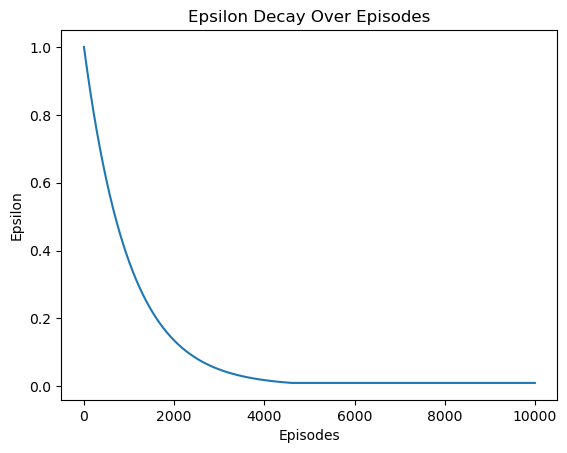

In [23]:
epsilon_start = 1.0  
epsilon_end = 0.01  
epsilon_decay = 0.999
max_episodes=10000
max_steps=500
episodes = np.arange(max_episodes)
epsilon_values = epsilon_start * (epsilon_decay ** episodes)
epsilon_values = np.maximum(epsilon_values, epsilon_end)

plt.plot(episodes, epsilon_values)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay Over Episodes')
plt.show()

In [12]:

# 4) Save frames as GIF
gif_path = "ddpg_laserhockey_episode.gif"
imageio.mimsave(gif_path, frames, fps=15)  # set fps as desired
print(f"Saved GIF to {gif_path}")

Saved GIF to ddpg_laserhockey_episode.gif


## Further Training on Strong Opponent

In [7]:
# --- 5. training the agent ---

final_metrics = trainer.train()

print("Training finished.")
print("Final metrics:", final_metrics)

2025-01-26 10:39:00 [INFO] Starting DDPG Training...
2025-01-26 10:39:00 [INFO] Environment: HockeyEnv, max_episodes=10000, max_timesteps=250, train_iter=32
2025-01-26 10:39:12 [INFO] Episode 20	Avg Length: 149.50	Avg Reward: -5.826
2025-01-26 10:39:24 [INFO] Episode 40	Avg Length: 192.70	Avg Reward: -8.411
2025-01-26 10:39:36 [INFO] Episode 60	Avg Length: 174.80	Avg Reward: -10.315
2025-01-26 10:39:48 [INFO] Episode 80	Avg Length: 163.25	Avg Reward: -4.667
2025-01-26 10:40:00 [INFO] Episode 100	Avg Length: 174.40	Avg Reward: -8.637
2025-01-26 10:40:13 [INFO] Episode 120	Avg Length: 197.00	Avg Reward: -10.635
2025-01-26 10:40:25 [INFO] Episode 140	Avg Length: 198.60	Avg Reward: -12.392
2025-01-26 10:40:38 [INFO] Episode 160	Avg Length: 169.95	Avg Reward: -7.034
2025-01-26 10:40:50 [INFO] Episode 180	Avg Length: 150.80	Avg Reward: -5.181
2025-01-26 10:41:03 [INFO] Episode 200	Avg Length: 143.15	Avg Reward: -12.133
2025-01-26 10:41:16 [INFO] Episode 220	Avg Length: 190.95	Avg Reward: -13

KeyboardInterrupt: 